## Linear Regression Model
We will be working with housing data for the city of Ames, Iowa, United States from 2006 to 2010. You can read more about why the data was collected [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627). You can also read about the different columns in the data [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import datetime
import seaborn as sns
%matplotlib inline

In [2]:
housing = pd.read_csv('AmesHousing.tsv', sep='\t')
housing.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
housing.shape

(2930, 82)

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

In [10]:
def transform_features(df):
    new_df = df.copy()

    #for columns with more than 25% missing values remove them
    missing_val_per = (new_df.isna().sum()/new_df.shape[0]) * 100
    missing_val_col = missing_val_per[missing_val_per > 25].index
    new_df = new_df.drop(missing_val_col, axis = 1)

    #For numeric columsn with less than 5% missing values fill them with most popular value for that column
    numeric_df = new_df.select_dtypes(exclude = 'object')
    nt_df = numeric_df.isna().sum()/numeric_df.shape[0]
    nt_cols = nt_df[(nt_df > 0) & (nt_df < 5)].index
    new_df[nt_cols] = new_df[nt_cols].fillna(new_df[nt_cols].mode().to_dict(orient = 'records')[0])
    

    #remove columns with missing values for categorical columns
    cat_df = new_df.select_dtypes(include = 'object')
    ct_df = cat_df.isna().sum()
    ct_cols = ct_df[ct_df > 0]
    new_df = new_df.drop(ct_cols.index, axis = 1)

    #remove columns that leak the sale price
    leakage = ['Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition']
    new_df = new_df.drop(leakage, axis = 1)
    
    #remove columns that convey no information
    noinfo = ['Order', 'PID']
    new_df = new_df.drop(noinfo, axis = 1)

    #Feature creation
    new_df['years_until_remod'] = datetime.datetime.now().year -new_df['Year Remod/Add']
    
    return new_df

In [11]:
def select_features(df):
    
    correlation = df.corr()
    plt.figure(figsize= (10,10))
    sns.heatmap(correlation)
    plt.show()
    cor = abs(correlation['SalePrice']).sort_values(ascending = False)
    df = df.drop(cor[cor < 0.4].index, axis =1) #Remove columns whose correlation are less than 0.4 (arbitary value)
    
    del_cols = [] # Ordinal values with more unique values
    transform_cols = [] #ordinal values that needs to be encodded
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    cat_cols = df.select_dtypes(include = 'object').columns
    for col in nominal_features:
        if col in df.columns:
            if df[col].value_counts().shape[0] > 10:
                del_cols.append(col)
            elif col in cat_cols:
                df[col] = df[col].astype('category')
                transform_cols.append(col)
                
    df = df.drop(del_cols, axis = 1)
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include = 'category'))], axis = 1)
    df = df.drop(transform_cols, axis = 1)
    return df
    

In [12]:
def train_and_test(df, k = 0):
    
    numeric_df = df.select_dtypes(include = ('int64', 'float64'))
    features = numeric_df.columns.drop('SalePrice')
    lr = LinearRegression()
    
    if k == 0:
        train = df.iloc[: 1460]
        test = df.iloc[1460: ]
        lr.fit(train[features], train["SalePrice"])
        predict = lr.predict(test[features])
        mse = mean_squared_error(test['SalePrice'], predict)
        rmse= np.sqrt(mse)
        return mse
    elif k == 1:
        shuffled_df = df.sample(frac = 1,)
        train = df.iloc[: 1460]
        test = df.iloc[1460: ]
        
        lr.fit(train[features], train["SalePrice"])
        predict = lr.predict(test[features])
        mse1 = mean_squared_error(test['SalePrice'], predict)
        rmse1 = np.sqrt(mse)
        
        lr.fit(test[features], test["SalePrice"])
        predict = lr.predict(train[features])
        mse2 = mean_squared_error(train['SalePrice'], predict)
        rmse2 = np.sqrt(mse)
        
        avg_rmse = (rmse1 + rmse2)/ 2
        return avg_rmse
    else:
        kf = KFold(n_splits = k, shuffle = True)
        rmse_values = []
        for train_index, test_index in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predict = lr.predict(test[features])
            mse = mean_squared_error(test['SalePrice'], predict)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        return np.mean(rmse_values)

#     lr.fit(select_features(), train['SalePrice'])
#     lr.predict()
#     mse = mean_squared_error()
#     return np.sqrt(mse)
    

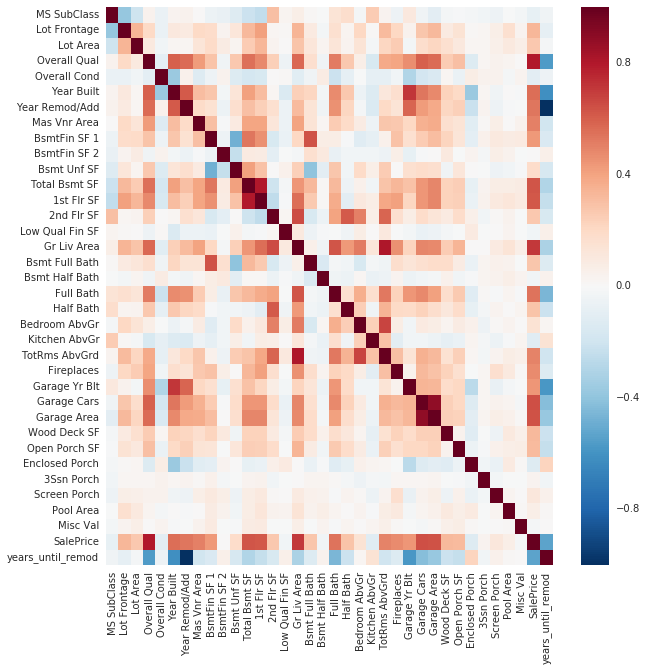

NameError: name 'KFold' is not defined

In [15]:
transform_df = transform_features(housing)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, 4)

rmse

Overall Qual is highly correlated with SalePrice, while there are also few columns like BsmtFin SF 2 which is not correlated. Such columns were removed.

In [14]:
transform_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 61 columns):
MS SubClass          2930 non-null int64
MS Zoning            2930 non-null object
Lot Frontage         2930 non-null float64
Lot Area             2930 non-null int64
Street               2930 non-null object
Lot Shape            2930 non-null object
Land Contour         2930 non-null object
Utilities            2930 non-null object
Lot Config           2930 non-null object
Land Slope           2930 non-null object
Neighborhood         2930 non-null object
Condition 1          2930 non-null object
Condition 2          2930 non-null object
Bldg Type            2930 non-null object
House Style          2930 non-null object
Overall Qual         2930 non-null int64
Overall Cond         2930 non-null int64
Year Built           2930 non-null int64
Year Remod/Add       2930 non-null int64
Roof Style           2930 non-null object
Roof Matl            2930 non-null object
Exterior 1st    